<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#RecA-deep-mutational-scanning-libraries" data-toc-modified-id="RecA-deep-mutational-scanning-libraries-1">RecA deep mutational scanning libraries</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span></li><li><span><a href="#Target-amplicon" data-toc-modified-id="Target-amplicon-1.2">Target amplicon</a></span></li><li><span><a href="#PacBio-CCSs" data-toc-modified-id="PacBio-CCSs-1.3">PacBio CCSs</a></span></li><li><span><a href="#Align-and-parse-CCSs" data-toc-modified-id="Align-and-parse-CCSs-1.4">Align and parse CCSs</a></span></li><li><span><a href="#Per-barcode-consensus-sequences" data-toc-modified-id="Per-barcode-consensus-sequences-1.5">Per-barcode consensus sequences</a></span></li></ul></li></ul></div>

# RecA deep mutational scanning libraries
This example shows how to use `alignparse` to process PacBio circular consensus sequencing of a barcoded library of RecA variants for deep mutational scanning.

## Set up for analysis
Import necessary Python modules.
We use `alignparse` for most of the operations, [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting, and a few functitons from [dms_variants](https://jbloomlab.github.io/dms_variants):

In [1]:
import os
import warnings

import numpy

import pandas as pd

from plotnine import *

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [3]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Directory for output:

In [4]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of an amplicon that includes the RecA gene along with barcodes and several other features.
The amplicon is defined as a Genbank file.
First, let's look at that file.
Note how it defines the features; this is how they must be defined to be handled by `alignparse`.
Note also how there are ambiguous nucleotides in the barcode and variant tag regions:

In [5]:
recA_targetfile = 'input_files/recA_amplicon.gb'

with open(recA_targetfile) as f:
    print(f.read())

LOCUS       RecA_PacBio_amplicon    1342 bp ds-DNA     linear       06-AUG-2018
DEFINITION  PacBio amplicon for deep mutational scanning of E. coli RecA.
ACCESSION   None
VERSION     
SOURCE      Danny Lawrence
  ORGANISM  .
COMMENT     PacBio amplicon for RecA libraries.
COMMENT     There are single nucleotide tags in the 5' and 3' termini to measure strand exchange.
FEATURES             Location/Qualifiers
     termini5        1..147
                     /label="termini 5' of gene"
     gene            148..1206
                     /label="RecA gene"
     spacer          1207..1285
                     /label="spacer between gene & barcode"
     barcode         1286..1303
                     /label="18 nucleotide barcode"
     termini3        1304..1342
                     /label="termini 3' of barcode"
     variant_tag5    33..33
                     /label="5' variant tag"
     variant_tag3    1311..1311
                     /label="3' variant tag"
ORIGIN
        1 gcacggcgtc ac

Along with the Genbank file giving the sequence of the amplicon, we have a YAML file specifying how to filter and parse alignments to this amplicon.
Below is the text of the YAML file.

As you can see below, the YAML file specifies how well alignments must match the target in order to be retained.
The query clipping indicates the max amount of the query that can be clipped at each end prior to the alignment.
For each feature, there is a number indicating the max allowable number of nucleotides of that feature can be clipped in the alignment, as well as the max allowable number of mutated nucleotides (indels count in proportion to the number of nucleotide mutations) and mutation "operations" (indels count as one operation regardless of size).
Below the mutation operation filter is all set to `null`, meaning that for this analysis all the filtering is done on the number of mutated nucleotides.
When filters are missing for a feature, they are automatically set to zero.

The YAML file also specifies what information is parsed from alignments that are not filtered.
As you can see, for some features we parse the mutations or the full sequence of the feature, along with the accuracy of that feature in the sequencing query (computed from the Q-values):

In [6]:
recA_parse_specs_file = 'input_files/recA_feature_parse_specs.yaml'
with open(recA_parse_specs_file) as f:
    print(f.read())

RecA_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
    return: [mutations, accuracy]
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
  barcode:
    return: [sequence, accuracy]
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
  variant_tag5:
    return: sequence
  variant_tag3:
    return: sequence



We now read the amplicon into an `alignparse.targets.Targets` object with the feature-parsing specs:

In [7]:
targets = alignparse.targets.Targets(
                seqsfile=recA_targetfile,
                feature_parse_specs=recA_parse_specs_file)

(Note that although we just have one target in this example, there can be multiple targets specifies in `seqsfile` and `feature_parse_specs` when initializing a `Targets`.)

We can plot the `Targets` object:

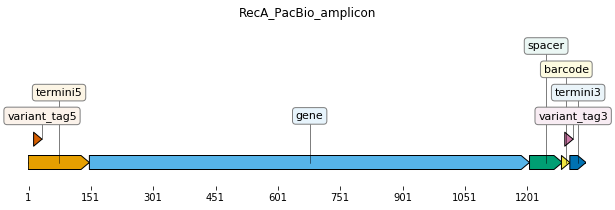

In [8]:
_ = targets.plot(ax_width=10)

We can also look at the featue parsing specifications as a dict or YAML string (here we do it as YAML string).
Note that all the defaults that were not specified in the YAML file above have now been filled in:

In [9]:
print(targets.feature_parse_specs('yaml'))

RecA_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  barcode:
    return:
    - sequence
    - accuracy
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []
  variant_tag5:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag3:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op

## PacBio CCSs
We will align and parse PacBio circular consensus sequences (CCSs).
FASTQ files with these CCSs along with associated report files were generated from the PacBio subreads `*.bam` file using the PacBio `ccs` program, version 4.0.0, (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using a command like the following:

    ccs \
        --min-length 50 \
        --max-length 5000 \
        --min-passes 3 \
        --min-rq 0.999 \
        --report-file recA_lib-1_report.txt \
        --num-threads 16 \
        recA_lib-1_subreads.bam \
        recA_lib-1_ccs.fastq
   
Note that to make this example fast, we have extracted just a few hundred CCSs from the $>10^5$ typically produced in a single PacBio run.

Here is a data frame with the names of the FASTQ files and reports generated by the PacBio `ccs` program:

In [10]:
run_names = ['recA_lib-1', 'recA_lib-2']
libraries = ['lib-1', 'lib-2']
ccs_dir = 'input_files'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'library': libraries,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

pacbio_runs

,name,library,report,fastq
0,recA_lib-1,lib-1,input_files/recA_lib-1_report.txt,input_files/recA_lib-1_ccs.fastq
1,recA_lib-2,lib-2,input_files/recA_lib-2_report.txt,input_files/recA_lib-2_ccs.fastq


We create a `alignparse.ccs.Summaries` object for these CCSs:

In [11]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

(Note if you did not have the `ccs` reports, you could still do the steps above but would need to set `report_col=None` when creating the `Summaries` objectt, and then you could not analyze ZMW stats as done below.)

Plot how many ZMWs yielded CCSs:

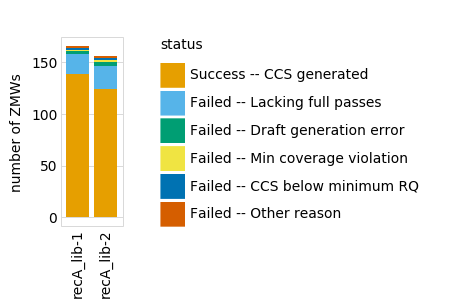

In [12]:
p = ccs_summaries.plot_zmw_stats()
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

We can also get the ZMW stats as numerical values:

In [13]:
ccs_summaries.zmw_stats()

,name,status,number,fraction
0,recA_lib-1,Success -- CCS generated,139,0.837349
1,recA_lib-1,Failed -- Lacking full passes,19,0.114458
2,recA_lib-1,Failed -- Draft generation error,3,0.018072
3,recA_lib-1,Failed -- Min coverage violation,1,0.006024
4,recA_lib-1,Failed -- CCS below minimum RQ,2,0.012048
5,recA_lib-1,Failed -- Other reason,2,0.012048
6,recA_lib-2,Success -- CCS generated,124,0.794872
7,recA_lib-2,Failed -- Lacking full passes,22,0.141026
8,recA_lib-2,Failed -- Draft generation error,4,0.025641
9,recA_lib-2,Failed -- Min coverage violation,2,0.012821


Statistics on the CCSs (length, number of subread passes, quality):

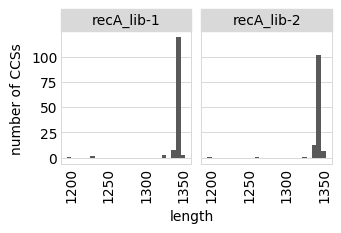

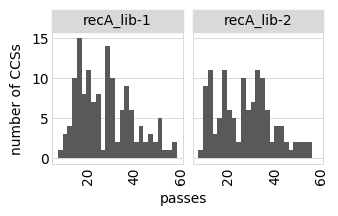

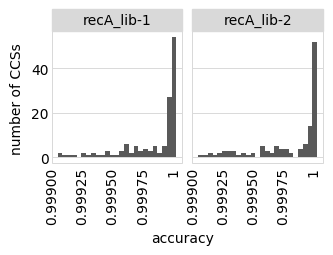

In [14]:
for stat in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(stat):
        p = ccs_summaries.plot_ccs_stats(stat)
        p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
        _ = p.draw()
    else:
        print(f"No {stat} statistics available.")

We can also get these statistics numerically; for instance:

In [15]:
ccs_summaries.ccs_stats('length').head(n=5)

,name,length
0,recA_lib-1,1325
1,recA_lib-1,1340
2,recA_lib-1,1339
3,recA_lib-1,985
4,recA_lib-1,1196


## Align and parse CCSs
Now we align the CCSs using our `Targets` object, and parse the features from queries that align sufficiently well.

First, we create an `alignparse.minimap2.Mapper` object to run [minimap2](https://github.com/lh3/minimap2), which is used for the alignments.
We use `minimap2` options that are tailored for codon-level deep mutational scanning experiments like this one (these are specified by `alignparse.minimap2.OPTIONS_CODON_DMS`):

In [16]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --score-N=4 --secondary=no --cs


We now use `Targets.align_and_parse` to align and parse our FASTQ files of CCSs.
(Note that if needed, you can also perform each of these steps separately for each FASTQ file by running `Targets.align` and `Targets.parse_alignments` separately.)

First, we define a directory to place the created files:

In [17]:
align_and_parse_outdir = os.path.join(outdir, 'RecA_align_and_parse')

Now we run `Targets.align_and_parse` on all the CCS sets in the data frame `pacbio_runs`, which we set up above to specify information on each PacBio run.
The `name_col` gives the column in the data frame giving the name of each run, the `queryfile_col` gives the column with the FASTQ file for that run, and `group_cols` specifies any columns showing how to group runs when aggregating results (here we aggregate results by library):

In [18]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        group_cols=['library'],
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

The return value from running the function above is a tuple of three elements: `readstats`, `aligned`, and `filtered`.
We go through these one by one.

The `readstats` variable is a data frame that gives summary statistics for each run:

In [19]:
readstats

,library,name,category,count
0,lib-1,recA_lib-1,aligned RecA_PacBio_amplicon,123
1,lib-1,recA_lib-1,filtered RecA_PacBio_amplicon,20
2,lib-1,recA_lib-1,unmapped,0
3,lib-2,recA_lib-2,aligned RecA_PacBio_amplicon,112
4,lib-2,recA_lib-2,filtered RecA_PacBio_amplicon,12
5,lib-2,recA_lib-2,unmapped,0


Above we see that all reads mapped to our single target (`RecA_PacBio_amplicon`), and that most could be fully aligned and parsed given our `feature_parse_specs`, but that some were filtered for not passing these specs.

We can plot `readstats` for easy viewing:

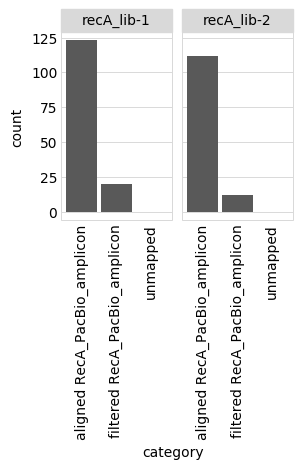

In [20]:
p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5),
          panel_grid_major_x=element_blank()  # no vertical grid lines
          )
    )
_ = p.draw()

The `aligned` variable is a dict that is keyed by each target name, and then gives a data frame with information on all queries (CCSs) that were successfully aligned and parsed:

In [21]:
for target in targets.target_names:
    print(f"First few lines of parsed alignments for {target}")
    display(aligned[target].head())

First few lines of parsed alignments for RecA_PacBio_amplicon


,library,name,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,barcode_sequence,barcode_accuracy,variant_tag5_sequence,variant_tag3_sequence
0,lib-1,recA_lib-1,m54228_180801_171631/4915465/ccs,0,0,C142G G144T T329A A738G A946T C947A,1.000000,AAATATCATCGCGGCCAG,1.0,T,T
1,lib-1,recA_lib-1,m54228_180801_171631/4981392/ccs,0,0,C142G G144T T329A A738G A946T C947A,1.000000,AAATATCATCGCGGCCAG,1.0,G,C
2,lib-1,recA_lib-1,m54228_180801_171631/6029553/ccs,0,0,T83A G84A A106T T107A G108A ins693G G862T C863...,0.999940,CTAATAGTAGTTTTCCAG,1.0,G,C
3,lib-1,recA_lib-1,m54228_180801_171631/6488565/ccs,0,0,A254C G255T A466T T467G C468T C940G G942A,0.999967,TATTTATACCCATGAGTG,1.0,A,T
4,lib-1,recA_lib-1,m54228_180801_171631/6684785/ccs,0,0,ins735G,0.999970,ACTCACAAGCCGAGTCAA,1.0,A,T


Since we have just one target, we get the data frame in `aligned` for that single target into a new variable (`aligned_df`) and save it for analysis in the next subsection.
We also extract just the columns of interest from the data frame, and rename `barcode_sequence` to the shorter name of `barcode`.
Also, since real analyses of the barcode typically involve Illumina sequencing it in the reverse direction, we make this new `barcode` column the **reverse complement** of `barcode_sequence`:

In [22]:
assert len(aligned) == 1, 'not just one target'

aligned_df = (
    aligned[targets.target_names[0]]
    .assign(barcode=lambda x: x['barcode_sequence'].map(
                dms_variants.utils.reverse_complement))
    [['library', 'name', 'query_name', 'barcode', 'gene_mutations',
      'barcode_accuracy', 'gene_accuracy']]
    )

aligned_df.head()

,library,name,query_name,barcode,gene_mutations,barcode_accuracy,gene_accuracy
0,lib-1,recA_lib-1,m54228_180801_171631/4915465/ccs,CTGGCCGCGATGATATTT,C142G G144T T329A A738G A946T C947A,1.0,1.000000
1,lib-1,recA_lib-1,m54228_180801_171631/4981392/ccs,CTGGCCGCGATGATATTT,C142G G144T T329A A738G A946T C947A,1.0,1.000000
2,lib-1,recA_lib-1,m54228_180801_171631/6029553/ccs,CTGGAAAACTACTATTAG,T83A G84A A106T T107A G108A ins693G G862T C863...,1.0,0.999940
3,lib-1,recA_lib-1,m54228_180801_171631/6488565/ccs,CACTCATGGGTATAAATA,A254C G255T A466T T467G C468T C940G G942A,1.0,0.999967
4,lib-1,recA_lib-1,m54228_180801_171631/6684785/ccs,TTGACTCGGCTTGTGAGT,ins735G,1.0,0.999970


Finally, the `filtered` variable gives information on why queries that aligned but were filtered (failed `feature_parse_specs`) were filtered.
Like `aligned`, `filtered` is a dict keyed by target name with values being data frames giving the information:

In [23]:
for target in targets.target_names:
    print(f"First few lines of filtering information for {target}")
    display(filtered[target].head())

First few lines of filtering information for RecA_PacBio_amplicon


,library,name,query_name,filter_reason
0,lib-1,recA_lib-1,m54228_180801_171631/4194459/ccs,spacer mutation_nt_count
1,lib-1,recA_lib-1,m54228_180801_171631/4325806/ccs,barcode mutation_nt_count
2,lib-1,recA_lib-1,m54228_180801_171631/4391313/ccs,termini3 mutation_nt_count
3,lib-1,recA_lib-1,m54228_180801_171631/4391375/ccs,gene clip3
4,lib-1,recA_lib-1,m54228_180801_171631/4391467/ccs,gene clip3


As can be seen above, the `filter_reason` column gives which particular specification in `feature_parse_specs` was not met.

Plot this inforrmation:

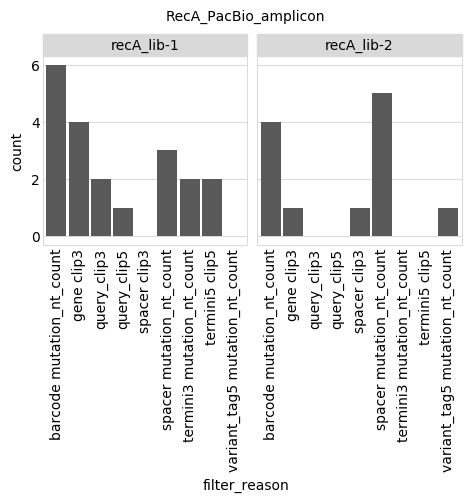

In [24]:
for targetname in targets.target_names:
    target_filtered = filtered[targetname]
    nreasons = target_filtered['filter_reason'].nunique()
    p = (
        ggplot(target_filtered, aes('filter_reason')) +
        geom_bar() +
        facet_wrap('~ name', nrow=1) +
        labs(title=targetname) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(0.3 * nreasons * len(pacbio_runs), 2.5),
              panel_grid_major_x=element_blank()  # no vertical grid lines
              )
        )
    _ = p.draw()

The example usage of `Targets.align_and_parse` above read all of the information on the parsed alignments into data frames.
For large data sets, these data frames might be so large that you don't want to read them into memory.
In that case, use the `to_csv` option, which makes `Targets.align_and_parse` simply give the locations of CSV files holding the data frames.
Here is an example:

In [25]:
readstats_csv, aligned_csv, filtered_csv = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        group_cols=['library'],
        to_csv=True,
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

Now the returned information on the parsed alignments and filtering just gives the locations of the CSV files for the data frames:

In [26]:
print(aligned_csv)
print(filtered_csv)

{'RecA_PacBio_amplicon': './output_files/RecA_align_and_parse/RecA_PacBio_amplicon_aligned.csv'}
{'RecA_PacBio_amplicon': './output_files/RecA_align_and_parse/RecA_PacBio_amplicon_filtered.csv'}


Note that since no mutations are specified as empty strings in these CSV files, if you read them using `pandas.read_csv`, you then need to do so using `na_filter=None` (i.e., `pandas.read_csv(<csv_file>, na_filter=None)`) so that empty strings are not converted to `nan` values.

Here are all of the files created by running `Targets.align_and_parse` (they also include SAM alignments and parsing results for each individual run):

In [27]:
print(f"Contents of {align_and_parse_outdir}:\n" + '-' * 48)
for d, _, fs in sorted(os.walk(align_and_parse_outdir)):
    for f in sorted(fs):
        print('  ' + os.path.relpath(os.path.join(d, f),
                                     align_and_parse_outdir))

Contents of ./output_files/RecA_align_and_parse:
------------------------------------------------
  RecA_PacBio_amplicon_aligned.csv
  RecA_PacBio_amplicon_filtered.csv
  lib-1_recA_lib-1/RecA_PacBio_amplicon_aligned.csv
  lib-1_recA_lib-1/RecA_PacBio_amplicon_filtered.csv
  lib-1_recA_lib-1/alignments.sam
  lib-2_recA_lib-2/RecA_PacBio_amplicon_aligned.csv
  lib-2_recA_lib-2/RecA_PacBio_amplicon_filtered.csv
  lib-2_recA_lib-2/alignments.sam


## Per-barcode consensus sequences
In a deep mutational scanning experiment, we typically want to determine the sequence of the gene variant associated with each barcode.
In this section, we do that--and also estimate the empirical accuracy of the sequencing by determining how often two sequences with the same barcode are identical.

We start with the `aligned_df` data frame generated in the previous subsection.
First, we want to plot the distribution of accuracies for the barcodes and genes.
Because these span a wide range, it's most convenient to convert the accuracies into error rates (1 - accuracy), and then plot these error rates on a log scale.
In order to do this, we also need to set some floor for the error rates since zero can't be plotted on a log scale.
Compute these "floored" error rates:

In [28]:
error_rate_floor = 1e-7  # error rates < this set to this

aligned_df = (
    aligned_df
    .assign(
        barcode_error=lambda x: numpy.clip(1 - x['barcode_accuracy'],
                                           error_rate_floor, None),
        gene_error=lambda x: numpy.clip(1 - x['gene_accuracy'],
                                        error_rate_floor, None)
        )
    )

We anticipate excluding all CCSs for which the error rate for either the gene or barcode is $>10^{-4}$.
Specify this cutoff:

In [29]:
error_cutoff = 1e-4

Now plot the distributiton of these error rates, drawing an orange vertical line at the cutoff:

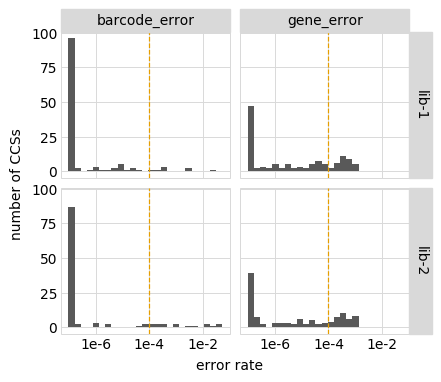

In [30]:
p = (
 ggplot(aligned_df
        .melt(id_vars=['library'],
              value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'),
        aes('error rate')) +
 geom_histogram(bins=25) +
 geom_vline(xintercept=error_cutoff,
            linetype='dashed',
            color=CBPALETTE[1]) +
 facet_grid('library ~ feature_type') +
 theme(figure_size=(4.5, 2 * len(libraries))) +
 ylab('number of CCSs') +
 scale_x_log10()
 )

_ = p.draw()

The plot above shows that a modest number of CCSs fail the error-rate filters (are to the right of the cutoff).

We mark to retain the CCSs that pass the filters:

In [31]:
aligned_df = (
    aligned_df
    .assign(retained=lambda x: ((x['gene_error'] <= error_cutoff) &
                                (x['barcode_error'] <= error_cutoff))
           )
    )

Here are the numbers retained:

In [32]:
(aligned_df
 .groupby(['library', 'retained'])
 .size()
 .rename('number of CCSs')
 .reset_index()
 )

,library,retained,number of CCSs
0,lib-1,False,33
1,lib-1,True,90
2,lib-2,False,39
3,lib-2,True,73


Before getting the consensus sequence for each barcode, we next want to know how many different CCSs we have per barcode among the retained CCSs.
Plot this distribution:

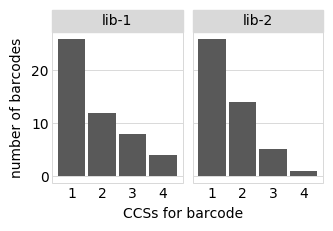

In [33]:
max_CCSs = 8 # in plot, group barcodes with >= this many CCSs

p = (
 ggplot(
    aligned_df
     .query('retained')
     .groupby(['library', 'barcode'])
     .size()
     .rename('nseqs')
     .reset_index()
     .assign(nseqs=lambda x: numpy.clip(x['nseqs'], None, max_CCSs)),
    aes('nseqs')) +
 geom_bar() +
 facet_wrap('~ library', nrow=1) +
 theme(figure_size=(1.75 * len(libraries), 2),
       panel_grid_major_x=element_blank(),  # no vertial tick lines
       ) +
 ylab('number of barcodes') +
 xlab('CCSs for barcode')
 )

_ = p.draw()

We see above that barcodes are often sequenced just once, but are also often sequenced two or more times.

From the barcodes with multiple CCSs, we can estimate the true (or "empirical") accuracy of the CCSs.
This is different than the purported accuracy returned by the `ccs` program and plotted above.
Those `ccs` accuracies are PacBio's estimation of accuracy from the sequencing, but they may not be fully correct.
In addition, not all the "error" comes from pure sequencing errors: we can also have experimental factors such as barcode collisions (two different variants sharing the same barcode) or PCR strand exchange make molecules with the same barcode actually different.

The concept of empirical accuracy is quite simple: we look to see how often CCSs with the same barcode actually have the same gene sequence.
If the sequencing is accurate and their aren't additional experimental factors causing effective errors, then CCSs with the same barcode will always be identical.
The less often they are identical, the lower the empirical accuracy.
The actual calculation of empirical accuracy is implemented in `alignparse.consensus.empirical_accuracy` (see the docs of that function for a full explanation of the calculation).

In addition, we'd like to split out the analysis by whether or not the CCSs have an indel.
The reason is that indels are the main source of error in PacBio sequencing, but we plan to disregard all sequences with indels anyway.
So first use `alignparse.consensus.add_mut_info_cols` to add information about whether the CCSs have indels:

In [34]:
aligned_df = alignparse.consensus.add_mut_info_cols(
                    aligned_df,
                    mutation_col='gene_mutations',
                    n_indel_col='n_indels')

aligned_df = aligned_df.assign(has_indel=lambda x: x['n_indels'] > 0)

Here are the numbers with and without indels among the retained CCSs:

In [35]:
(aligned_df
 .query('retained')
 .groupby(['library', 'has_indel'])
 .size()
 .rename('number_CCSs')
 .reset_index()
 )

,library,has_indel,number_CCSs
0,lib-1,False,76
1,lib-1,True,14
2,lib-2,False,65
3,lib-2,True,8


Now we can compute the empirical accuracy.
First, among all retained CCSs:

In [36]:
alignparse.consensus.empirical_accuracy(
            aligned_df.query('retained'),
            mutation_col='gene_mutations')

,library,accuracy
0,lib-1,0.864817
1,lib-2,0.786710


And excluding CCSs with indels:

In [37]:
alignparse.consensus.empirical_accuracy(
            aligned_df.query('retained & not has_indel'),
            mutation_col='gene_mutations')

,library,accuracy
0,lib-1,0.948033
1,lib-2,0.928539


As can be seen above, the empirical accuracy is quite a bit higher when excluding sequences with indels, which is what will happen in practice below.
However, the empirical accuracy is still much lower than the PacBio `ccs` estimated accuracy, since above we only retained CCSs with accuracy >99.99%.
This indicates that either the `ccs` estimated accuracies are not actually accurate, or other experimental factors also contribute to decrease the empirical accuracy.
You can play around with the filter on the `ccs`-estimated accuracies to see how they affect the empirical accuracy--but in general, we find on real (larger) datasets that beyond a point, increasing the filter on the `ccs`-estimated accuracies no longer further enhances the empirical accuracy.

Finally, we'd like to actually build a consensus sequence for each barcodes.
There are lots of existing programs with complex error models that use Q-values to build consensus sequences--but we instead use the simple approach implemented in `alignparse.consensus.simple_mutconsensus`.
The documentation for that function explains the method in detail, but basically it works like this:
 1. When there is just one CCS per barcode, the consensus is just that sequence.
 2. When there are multiple CCSs per barcode, they are used to build a consensus--however, the entire barcode is discarded if there are many differences between CCSs with the barcode, or high-frequency non-consensus mutations. The reason that barcodes are discarded in such cases as many differences between CCSs or high-frequency non-consensus mutations suggest errors such as barcode collisions or PCR strand exchange.
 
The advantage of this simple method is that it tries to throw away barcodes for which there is likely to be some source of experimental error.

Build the consensus sequences:

In [38]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        aligned_df.query('retained'),
                        group_cols=('library', 'barcode'),
                        mutation_col='gene_mutations',
                        )

Note how we get back two data frames.
The `consensus` data frame simply gives the consensus sequences:

In [39]:
consensus.head()

,library,barcode,gene_mutations,variant_call_support
0,lib-1,AAAGTCTGACCGAAAAAA,C154A G509C T510A C823G T824G G825T del763to763,1
1,lib-1,AACACGTTATAGATGTAG,A52C T53C T54C C85A C87G T277G T278A C296A G297C,3
2,lib-1,AGACCGGGCGGGGCCTAT,A526G G694A G715C A937G C939G,4
3,lib-1,AGAGAGATATTAAAAAAA,C22A A23C G24C G34A C35G G36A G400C G402C A631...,1
4,lib-1,ATCTCCTCTCCAAGCCGT,G326C C327A,1


In addition to the mutations in the consensus, it also gives the `variant_call_support`, which is the number of CCSs supporting the consensus call.
When the call support is one, then we expect the accuracy to be equal to the empirical ones we computed above (either with or without indels depending on whether we exclude consensus sequences with indels).
When the variant call support is greater than one, the accuracy will be higher as there are more CCSs supporting the consensus call.

It is often useful to get the mutations in `consensus` that are just substitutions, and also denote which sequences have indels.
That can be done as follows:

In [40]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col='gene_mutations',
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    overwrite_cols=True)

consensus.head()

,library,barcode,gene_mutations,variant_call_support,substitutions,number_of_indels
0,lib-1,AAAGTCTGACCGAAAAAA,C154A G509C T510A C823G T824G G825T del763to763,1,C154A G509C T510A C823G T824G G825T,1
1,lib-1,AACACGTTATAGATGTAG,A52C T53C T54C C85A C87G T277G T278A C296A G297C,3,A52C T53C T54C C85A C87G T277G T278A C296A G297C,0
2,lib-1,AGACCGGGCGGGGCCTAT,A526G G694A G715C A937G C939G,4,A526G G694A G715C A937G C939G,0
3,lib-1,AGAGAGATATTAAAAAAA,C22A A23C G24C G34A C35G G36A G400C G402C A631...,1,C22A A23C G24C G34A C35G G36A G400C G402C A631...,0
4,lib-1,ATCTCCTCTCCAAGCCGT,G326C C327A,1,G326C C327A,0


If you filter the data frame above for just those barcodes with no indels, you can then pass the data frame directly into a [dms_variants.codonvarianttable.CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) for further analysis.

You can also look at what happened to the barcodes for which we could **not** build consensus sequences by looking at the `dropped` data frame:

In [41]:
dropped

,library,barcode,drop_reason,nseqs
0,lib-1,CTATACCCAAATTAATAA,subs diff too large,2
1,lib-1,CTGATTTGGCTTTATTTT,subs diff too large,2
2,lib-2,CTGATATACGTACGCAAC,subs diff too large,3
3,lib-2,TACCCTGCCTCGCCGAAC,subs diff too large,2


Or to summarize the drop reasons:

In [42]:
(dropped
 .groupby('drop_reason')
 .size()
 .rename('number_barcodes')
 .reset_index()
 )

,drop_reason,number_barcodes
0,subs diff too large,4


We see that only a few barcodes were dropped, and that in all cases the reason was that the differences in number of substitutions among CCSs within the barcode was too large.